<a href="https://colab.research.google.com/github/Sanjana1125/FUTURE_ML_01/blob/main/jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip uninstall -y prophet fbprophet cmdstanpy
!pip install prophet cmdstanpy

Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.7 MB/s eta 0:00:00


CmdStan install directory: /root/.cmdstan
CmdStan version 2.37.0 already installed
Test model compilation
Test MAE: 12239.966364463957


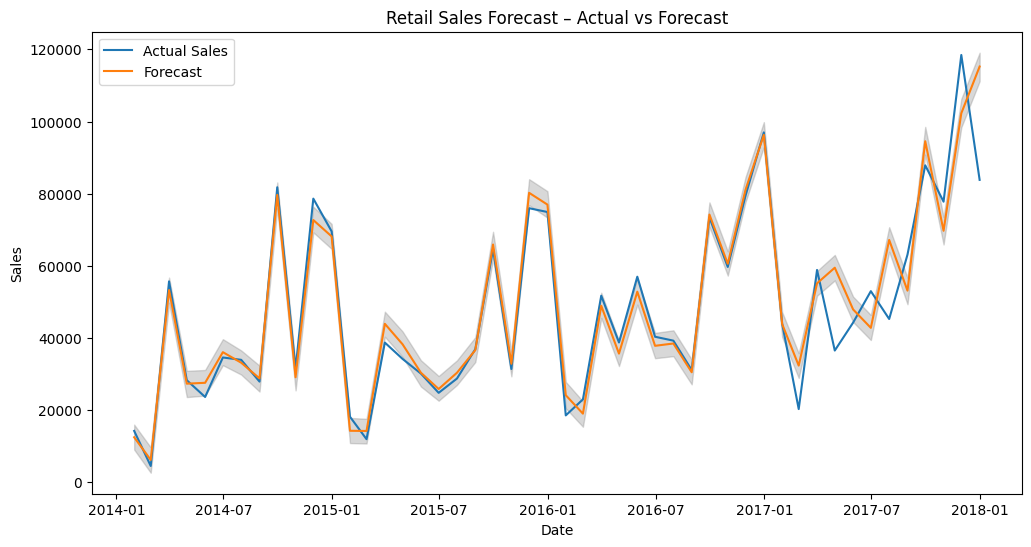

In [1]:


import cmdstanpy
cmdstanpy.install_cmdstan() # Installs CmdStan backend for Prophet

# ---- Step 1: Load and Clean Data ----
import pandas as pd
df = pd.read_csv('Sample - Superstore.csv', encoding='latin1')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.dropna(subset=['Sales'])
df = df.drop_duplicates()

# ---- Step 2: Aggregate Monthly Sales ----
monthly_sales = df.resample('ME', on='Order Date')['Sales'].sum().reset_index()

# ---- Step 3: Feature Engineering ----
monthly_sales['Month'] = monthly_sales['Order Date'].dt.month
monthly_sales['Year'] = monthly_sales['Order Date'].dt.year

# ---- Step 4: Create Holiday List ----
holiday_dates_list = [
    pd.Timestamp('2022-12-25'),
    pd.Timestamp('2023-01-01'),
    pd.Timestamp('2023-08-15'),
    pd.Timestamp('2023-10-02'),
    # Add more holidays as needed
]
holidays_df = pd.DataFrame({
    'holiday': 'holiday_flag',
    'ds': holiday_dates_list,
    'lower_window': 0,
    'upper_window': 1
})

# ---- Step 5: Train/Test Split ----
if len(monthly_sales) > 24:
    train = monthly_sales[:-12].rename(columns={'Order Date':'ds','Sales':'y'})
    test = monthly_sales[-12:].rename(columns={'Order Date':'ds','Sales':'y'})
else:
    train = monthly_sales.rename(columns={'Order Date':'ds','Sales':'y'})
    test = pd.DataFrame()

# ---- Step 6: Fit Prophet Model ----
from prophet import Prophet
model = Prophet(holidays=holidays_df, weekly_seasonality=True, daily_seasonality=False)
model.fit(train[['ds', 'y']])

# ---- Step 7: Forecast Next 12 Months ----
future = model.make_future_dataframe(periods=12, freq='ME')
forecast = model.predict(future)

# ---- Step 8: Evaluate Model ----
from sklearn.metrics import mean_absolute_error
if not test.empty:
    forecast_test = forecast[-12:]['yhat'].values
    actual_test = test['y'].values
    mae = mean_absolute_error(actual_test, forecast_test)
    print("Test MAE:", mae)

# ---- Step 9: Visualize Actual vs Forecast ----
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['Order Date'], monthly_sales['Sales'], label='Actual Sales')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='grey', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Retail Sales Forecast – Actual vs Forecast')
plt.legend()
plt.show()

# ---- Step 10: Export Data for Power BI Dashboard ----
forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv('monthly_forecast.csv', index=False)
monthly_sales.to_csv('monthly_actuals.csv', index=False)

